üîπ Step 1: ROI Labeling

üìå Cell 1: Import and Set Directory

In [1]:
import os
import pandas as pd

# ‚úÖ Set your image folder path
image_folder = r"C:\Users\Nafis\Desktop\VSCodeFiles\MLDLMother\Project_BreastCancer\BreastCancerUsingML\mammogram_old"


üìå Cell 2: Extract Labels from Filenames and Save

In [2]:
# ‚úÖ Extract labels and save to CSV
data = []
for filename in os.listdir(image_folder):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        label = (
            "Benign" if "benign" in filename.lower()
            else "Malignant" if "malign" in filename.lower()
            else "Normal" if "normal" in filename.lower()
            else None
        )
        if label:
            data.append((filename, label))

# Create DataFrame
df = pd.DataFrame(data, columns=["filename", "label"])

# Save as CSV
df.to_csv("roi_labels.csv", index=False)
print(f"‚úÖ Saved roi_labels.csv with {len(df)} entries.")
df.head()


‚úÖ Saved roi_labels.csv with 448 entries.


filename   label
0  benign001.jpeg  Benign
1  benign003.jpeg  Benign
2  benign005.jpeg  Benign
3  benign007.jpeg  Benign
4  benign009.jpeg  Benign

üîπ Step 2: Image Augmentation

üìå Cell 3: Import Libraries for Augmentation

In [3]:
import os
import cv2
import albumentations as A

üìå Cell 4: Set Input/Output Paths

In [5]:
# === Folders ===
input_folder = r"C:\Users\Nafis\Desktop\VSCodeFiles\MLDLMother\Project_BreastCancer\BreastCancerUsingML\mammogram_old"
output_folder = r"C:\Users\Nafis\Desktop\VSCodeFiles\MLDLMother\Project_BreastCancer\BreastCancerUsingML\mammogram_augmented"
os.makedirs(output_folder, exist_ok=True)


üìå Cell 5: Define Augmentation Pipeline

In [6]:
# === Albumentations Augmentation Pipeline ===
augmenter = A.Compose([
    A.HorizontalFlip(p=0.5),                # Horizontal flip
    A.Rotate(limit=20, p=0.7),              # Random rotation (higher p to reflect imgaug behavior)
    A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0, p=0.8)  # Brightness variation
])

üìå Cell 6: Apply Augmentation to Each Image

In [7]:
# === Loop through images ===
for filename in os.listdir(input_folder):
    if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue

    img_path = os.path.join(input_folder, filename)
    image = cv2.imread(img_path)

    if image is None:
        print(f"Skipping unreadable: {filename}")
        continue

    # Convert BGR to RGB for augmentation
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Create 2 augmentations per image
    for i in range(2):
        augmented = augmenter(image=image_rgb)
        aug_image = augmented["image"]

        # Convert back to BGR for saving
        aug_image_bgr = cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR)

        name, ext = os.path.splitext(filename)
        new_filename = f"{name}_aug{i+1}{ext}"
        output_path = os.path.join(output_folder, new_filename)

        cv2.imwrite(output_path, aug_image_bgr)
        print(f"‚úÖ Saved: {new_filename}")


‚úÖ Saved: benign001_aug1.jpeg
‚úÖ Saved: benign001_aug2.jpeg
‚úÖ Saved: benign003_aug1.jpeg
‚úÖ Saved: benign003_aug2.jpeg
‚úÖ Saved: benign005_aug1.jpeg
‚úÖ Saved: benign005_aug2.jpeg
‚úÖ Saved: benign007_aug1.jpeg
‚úÖ Saved: benign007_aug2.jpeg
‚úÖ Saved: benign009_aug1.jpeg
‚úÖ Saved: benign009_aug2.jpeg
‚úÖ Saved: benign011_aug1.jpeg
‚úÖ Saved: benign011_aug2.jpeg
‚úÖ Saved: benign013_aug1.jpeg
‚úÖ Saved: benign013_aug2.jpeg
‚úÖ Saved: benign015_aug1.jpeg
‚úÖ Saved: benign015_aug2.jpeg
‚úÖ Saved: benign016_aug1.jpeg
‚úÖ Saved: benign016_aug2.jpeg
‚úÖ Saved: benign018_aug1.jpeg
‚úÖ Saved: benign018_aug2.jpeg
‚úÖ Saved: benign020_aug1.jpeg
‚úÖ Saved: benign020_aug2.jpeg
‚úÖ Saved: benign022_aug1.jpeg
‚úÖ Saved: benign022_aug2.jpeg
‚úÖ Saved: benign023_aug1.jpeg
‚úÖ Saved: benign023_aug2.jpeg
‚úÖ Saved: benign025_aug1.jpeg
‚úÖ Saved: benign025_aug2.jpeg
‚úÖ Saved: benign027_aug1.jpeg
‚úÖ Saved: benign027_aug2.jpeg
‚úÖ Saved: benign029_aug1.jpeg
‚úÖ Saved: benign029_aug2.jpeg
‚úÖ Save

üîπ Step 3: Preprocessing, Segmentation, Feature Extraction

üìå Cell 1: Import Required Packages and Functions

In [42]:
import os
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from collections import Counter

# Import custom functions
from AMF import adaptive_median_filter
from segmentation import segment_with_hmrf, getbinary, threshold_label_map
from enhanced_feature_extraction import extract_all_features, select_features_with_pca


üìå Cell 2: Define Input/Output Paths and Create Output Folder

In [44]:
# Input and Output Paths
input_folders = [
    r"C:\Users\Nafis\Desktop\VSCodeFiles\MLDLMother\Project_BreastCancer\BreastCancerUsingML\mammogram_old",
    r"C:\Users\Nafis\Desktop\VSCodeFiles\MLDLMother\Project_BreastCancer\BreastCancerUsingML\mammogram_augmented"
]

output_folder = r"C:\Users\Nafis\Desktop\VSCodeFiles\MLDLMother\Project_BreastCancer\BreastCancerUsingML\processed_new\segmented"
feature_output = r"C:\Users\Nafis\Desktop\VSCodeFiles\MLDLMother\Project_BreastCancer\BreastCancerUsingML\processed_new\features_augmented__pca.csv"

Path(output_folder).mkdir(parents=True, exist_ok=True)


üìå Cell 3: main.py

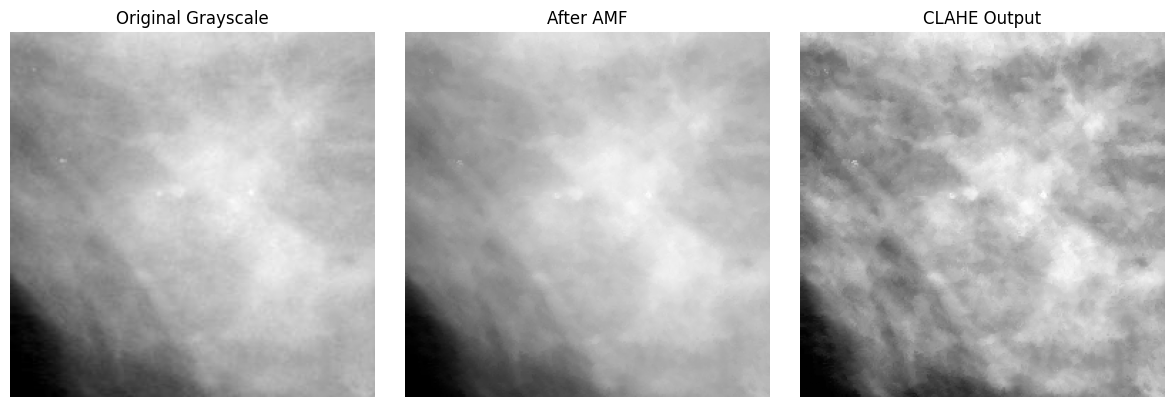

‚úÖ Processed: benign001.jpeg ‚Üí Benign
‚úÖ Processed: benign003.jpeg ‚Üí Benign
‚úÖ Processed: benign005.jpeg ‚Üí Benign
‚úÖ Processed: benign007.jpeg ‚Üí Benign
‚úÖ Processed: benign009.jpeg ‚Üí Benign
‚úÖ Processed: benign011.jpeg ‚Üí Benign
‚úÖ Processed: benign013.jpeg ‚Üí Benign
‚úÖ Processed: benign015.jpeg ‚Üí Benign
‚úÖ Processed: benign016.jpeg ‚Üí Benign
‚úÖ Processed: benign018.jpeg ‚Üí Benign
‚úÖ Processed: benign020.jpeg ‚Üí Benign
‚úÖ Processed: benign022.jpeg ‚Üí Benign
‚úÖ Processed: benign023.jpeg ‚Üí Benign
‚úÖ Processed: benign025.jpeg ‚Üí Benign
‚úÖ Processed: benign027.jpeg ‚Üí Benign
‚úÖ Processed: benign029.jpeg ‚Üí Benign
‚úÖ Processed: benign031.jpeg ‚Üí Benign
‚úÖ Processed: benign034.jpeg ‚Üí Benign
‚úÖ Processed: benign035.jpeg ‚Üí Benign
‚úÖ Processed: benign037.jpeg ‚Üí Benign
‚úÖ Processed: benign039.jpeg ‚Üí Benign
‚úÖ Processed: benign041.jpeg ‚Üí Benign
‚úÖ Processed: benign043.jpeg ‚Üí Benign
‚úÖ Processed: benign045.jpeg ‚Üí Benign
‚úÖ Processed: b

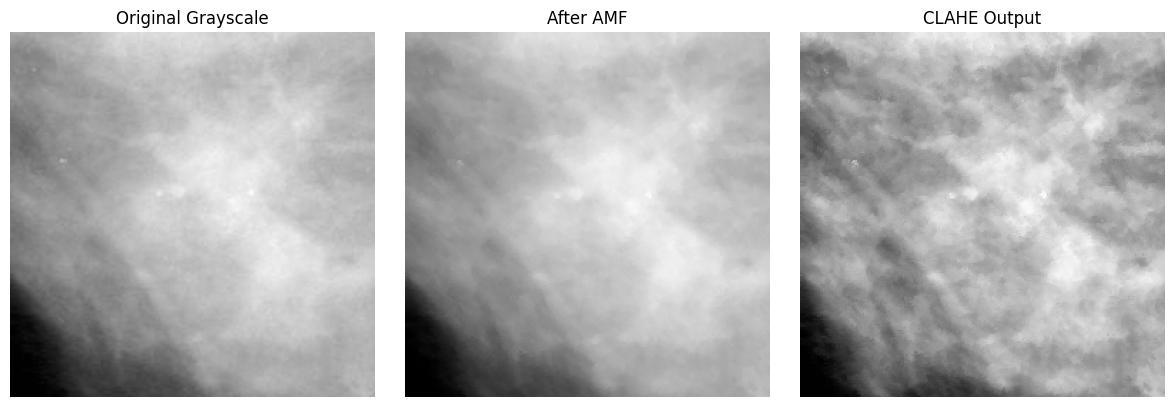

‚úÖ Processed: benign001_aug1.jpeg ‚Üí Benign


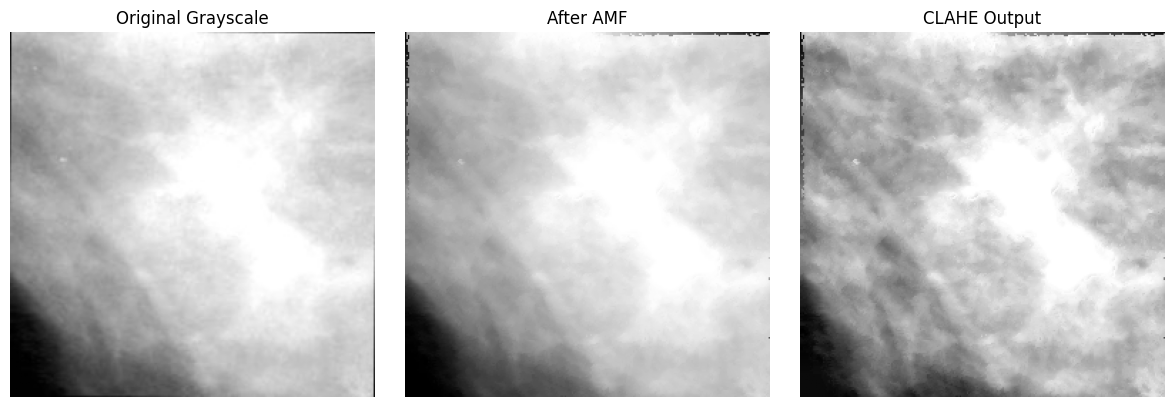

‚úÖ Processed: benign001_aug2.jpeg ‚Üí Benign
‚úÖ Processed: benign003_aug1.jpeg ‚Üí Benign
‚úÖ Processed: benign003_aug2.jpeg ‚Üí Benign
‚úÖ Processed: benign005_aug1.jpeg ‚Üí Benign
‚úÖ Processed: benign005_aug2.jpeg ‚Üí Benign
‚úÖ Processed: benign007_aug1.jpeg ‚Üí Benign
‚úÖ Processed: benign007_aug2.jpeg ‚Üí Benign
‚úÖ Processed: benign009_aug1.jpeg ‚Üí Benign
‚úÖ Processed: benign009_aug2.jpeg ‚Üí Benign
‚úÖ Processed: benign011_aug1.jpeg ‚Üí Benign
‚úÖ Processed: benign011_aug2.jpeg ‚Üí Benign
‚úÖ Processed: benign013_aug1.jpeg ‚Üí Benign
‚úÖ Processed: benign013_aug2.jpeg ‚Üí Benign
‚úÖ Processed: benign015_aug1.jpeg ‚Üí Benign
‚úÖ Processed: benign015_aug2.jpeg ‚Üí Benign
‚úÖ Processed: benign016_aug1.jpeg ‚Üí Benign
‚úÖ Processed: benign016_aug2.jpeg ‚Üí Benign
‚úÖ Processed: benign018_aug1.jpeg ‚Üí Benign
‚úÖ Processed: benign018_aug2.jpeg ‚Üí Benign
‚úÖ Processed: benign020_aug1.jpeg ‚Üí Benign
‚úÖ Processed: benign020_aug2.jpeg ‚Üí Benign
‚úÖ Processed: benign022_aug1.jpeg

In [57]:
import os
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from collections import Counter

from enhanced_feature_extraction import select_features_with_pca, extract_all_features
from AMF import adaptive_median_filter
from segmentation import segment_with_hmrf, getbinary, threshold_label_map

# === CONFIG ===
input_folders = [
    r"C:\Users\Nafis\Desktop\VSCodeFiles\MLDLMother\Project_BreastCancer\BreastCancerUsingML\mammogram_old",
    r"C:\Users\Nafis\Desktop\VSCodeFiles\MLDLMother\Project_BreastCancer\BreastCancerUsingML\mammogram_augmented"
]

output_folder = r"C:\Users\Nafis\Desktop\VSCodeFiles\MLDLMother\Project_BreastCancer\BreastCancerUsingML\processed_new\segmented"
feature_output = r"C:\Users\Nafis\Desktop\VSCodeFiles\MLDLMother\Project_BreastCancer\BreastCancerUsingML\processed_new\features_augmented__pca.csv"

Path(output_folder).mkdir(parents=True, exist_ok=True)

features_list = []
labels = []

for folder in input_folders:
    for filename in os.listdir(folder):
        if not filename.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        # Label assignment
        fname_lower = filename.lower()
        if "benign" in fname_lower:
            label = "Benign"
        elif "malign" in fname_lower:
            label = "Malignant"
        elif "normal" in fname_lower:
            label = "Normal"
        else:
            print(f"‚ö†Ô∏è Skipping unlabeled image: {filename}")
            continue

        image_path = os.path.join(folder, filename)
        image = cv2.imread(image_path)
        if image is None:
            print(f"‚ö†Ô∏è Skipping unreadable image: {filename}")
            continue

        # === PREPROCESSING
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        denoised = adaptive_median_filter(gray)

        # === DEBUG PREVIEW (Optional)
        if filename.lower().startswith("benign001"):
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            enhanced = clahe.apply(denoised)
            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            axs[0].imshow(gray, cmap='gray')
            axs[0].set_title("Original Grayscale")
            axs[1].imshow(denoised, cmap='gray')
            axs[1].set_title("After AMF")
            axs[2].imshow(enhanced, cmap='gray')
            axs[2].set_title("CLAHE Output")
            for ax in axs: ax.axis('off')
            plt.tight_layout()
            plt.show()

        # === SEGMENTATION
        segmented = segment_with_hmrf(denoised, k=2, g=2, beta=1, EM_iter=10, MAP_iter=10)
        mask = threshold_label_map(gray, centroid=180)
        segmented_combined = np.logical_and(segmented == 255, mask == 255).astype(np.uint8) * 255
        overlay = getbinary(image, segmented_combined, centroid=180)

        # === FEATURE EXTRACTION
        features = extract_all_features(gray, segmented_combined)
        features.append(label)
        features_list.append(features)
        labels.append(label)

        # === Save overlay image
        cv2.imwrite(os.path.join(output_folder, filename), overlay)

        print(f"‚úÖ Processed: {filename} ‚Üí {label}")

# === Summary
print("\nüîç Final label distribution:", Counter(labels))

# === PCA + SAVE
features_only = np.array(features_list)[:, :-1].astype(float)
features_labels = [row[-1] for row in features_list]

features_pca, pca_model = select_features_with_pca(features_only, variance_threshold=0.95)
features_with_labels = np.column_stack([features_pca, features_labels])

columns = [f"pca_feature_{i}" for i in range(features_pca.shape[1])] + ["Label"]
df_pca = pd.DataFrame(features_with_labels, columns=columns)
df_pca.to_csv(feature_output, index=False)

print(f"‚úÖ PCA features saved to: {feature_output}")


üîπ Step 4: Check Class Distribution in PCA Feature File

üìå Cell 1: Import Required Packages

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


üìå Cell 2: Load PCA Feature CSV and Inspect

In [59]:
# ‚úÖ Load the PCA-balanced feature file
csv_path = r"C:\Users\Nafis\Desktop\VSCodeFiles\MLDLMother\Project_BreastCancer\BreastCancerUsingML\processed_new\features_augmented__pca.csv"
df = pd.read_csv(csv_path)

# Show a sample
df.head()


pca_feature_0   Label
0 -300285.929909  Benign
1 -300285.502342  Benign
2 -300285.643953  Benign
3 -300285.918334  Benign
4 -300285.602657  Benign

üìå Cell 3: Check Class Distribution

In [60]:
# ‚úÖ Count how many samples for each class label
label_counts = df["Label"].value_counts()
print("Label Distribution:\n", label_counts)

# Optional: Malignant count only
print(f"\nMalignant count: {label_counts.get('Malignant', 0)}")


Label Distribution:
 Label
Benign       681
Malignant    663
Name: count, dtype: int64

Malignant count: 663


üìå Cell 4: Plot Class Distribution

C:\Users\Nafis\AppData\Local\Temp\ipykernel_10648\861044882.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="Set2")


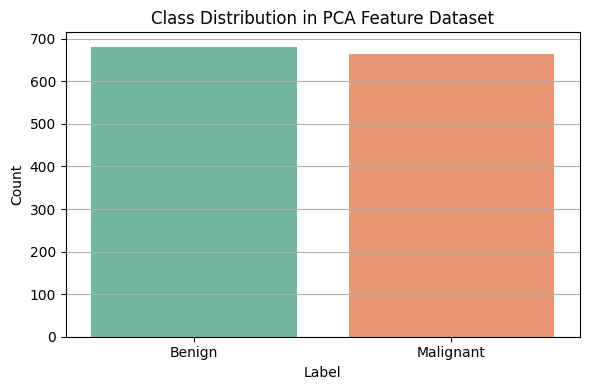

In [61]:
# ‚úÖ Bar plot for visual clarity
plt.figure(figsize=(6, 4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="Set2")
plt.title("Class Distribution in PCA Feature Dataset")
plt.xlabel("Label")
plt.ylabel("Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Step 5: Data Balancing (Undersampling)

üìå Cell 2: Load Unbalanced PCA Feature Data

In [62]:
import pandas as pd
from sklearn.utils import resample

# ‚úÖ Load the PCA feature dataset before balancing
csv_path = r"C:\Users\Nafis\Desktop\VSCodeFiles\MLDLMother\Project_BreastCancer\BreastCancerUsingML\processed_new\features_augmented__pca.csv"
df = pd.read_csv(csv_path)

# Quick check
df["Label"].value_counts()


Label
Benign       681
Malignant    663
Name: count, dtype: int64

üìå Cell 3: Separate Classes and Undersample

In [63]:
# Normalize label format
df["Label"] = df["Label"].str.strip().str.capitalize()

# Confirm class labels
print("Labels found:", df["Label"].unique())

# Separate classes
benign_df = df[df["Label"] == "Benign"]
malignant_df = df[df["Label"] == "Malignant"]

# Proceed only if both exist
if len(benign_df) == 0 or len(malignant_df) == 0:
    print("‚ùå One of the classes is missing. Cannot balance.")
else:
    min_size = min(len(benign_df), len(malignant_df))
    print("Balancing to size:", min_size)

    benign_bal = resample(benign_df, replace=False, n_samples=min_size, random_state=42)
    malignant_bal = resample(malignant_df, replace=False, n_samples=min_size, random_state=42)

    balanced_df = pd.concat([benign_bal, malignant_bal]).sample(frac=1, random_state=42).reset_index(drop=True)
    print("‚úÖ Balanced dataset shape:", balanced_df.shape)


Labels found: ['Benign' 'Malignant']
Balancing to size: 663
‚úÖ Balanced dataset shape: (1326, 2)


üìå Cell 4: Save the Balanced Dataset

In [64]:
# ‚úÖ Save the balanced dataset
output_path = r"C:\Users\Nafis\Desktop\VSCodeFiles\MLDLMother\Project_BreastCancer\BreastCancerUsingML\features_augmented_pca_balanced.csv"
balanced_df.to_csv(output_path, index=False)
print("‚úÖ Balanced dataset saved to:", output_path)


‚úÖ Balanced dataset saved to: C:\Users\Nafis\Desktop\VSCodeFiles\MLDLMother\Project_BreastCancer\BreastCancerUsingML\features_augmented_pca_balanced.csv


In [65]:
df = pd.read_csv(r"C:\Users\Nafis\Desktop\VSCodeFiles\MLDLMother\Project_BreastCancer\BreastCancerUsingML\processed_new\features_augmented__pca.csv")
print("Unique Labels:", df["Label"].unique())
print("Counts:\n", df["Label"].value_counts())


Unique Labels: ['Benign' 'Malignant']
Counts:
 Label
Benign       681
Malignant    663
Name: count, dtype: int64


üìå Cell 5: Visual Check of Final Distribution

C:\Users\Nafis\AppData\Local\Temp\ipykernel_10648\3879522196.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="Set2")


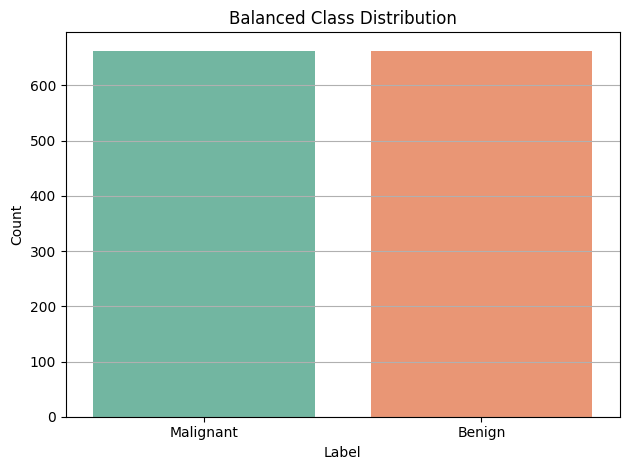

In [66]:
# ‚úÖ Plot final balanced class distribution
import matplotlib.pyplot as plt
import seaborn as sns

label_counts = balanced_df["Label"].value_counts()
sns.barplot(x=label_counts.index, y=label_counts.values, palette="Set2")
plt.title("Balanced Class Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


üîπ Step 6: Feature Selection via Correlation

üìå Cell 2: Load Balanced PCA Dataset

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
# Load the balanced feature dataset
csv_path = r"C:\Users\Nafis\Desktop\VSCodeFiles\MLDLMother\Project_BreastCancer\BreastCancerUsingML\features_augmented_pca_balanced.csv"
df = pd.read_csv(csv_path)

# Label encode the target
df["Label_encoded"] = LabelEncoder().fit_transform(df["Label"])


üìå Cell 3: Compute Feature Correlation

In [68]:
# Drop string label column
corr_matrix = df.drop(columns=["Label"]).corr()

# Correlation with the encoded label
label_corr = corr_matrix["Label_encoded"].drop("Label_encoded")

# Preview top correlations
label_corr.abs().sort_values(ascending=False).head(10)


pca_feature_0    0.027468
Name: Label_encoded, dtype: float64

üìå Cell 4: Select Top 10 Features + Save CSV

In [69]:
# Select top 10 features
top_features = label_corr.abs().sort_values(ascending=False).head(10).index.tolist()
top_features.append("Label")  # Keep original label for classification

df_top = df[top_features]
output_path = "processed/features_top10.csv"
df_top.to_csv(output_path, index=False)

print(f"‚úÖ Top 10 features saved to: {output_path}")


‚úÖ Top 10 features saved to: processed/features_top10.csv


üìå Cell 5: Plot Feature‚ÄìLabel Correlation Bar Chart

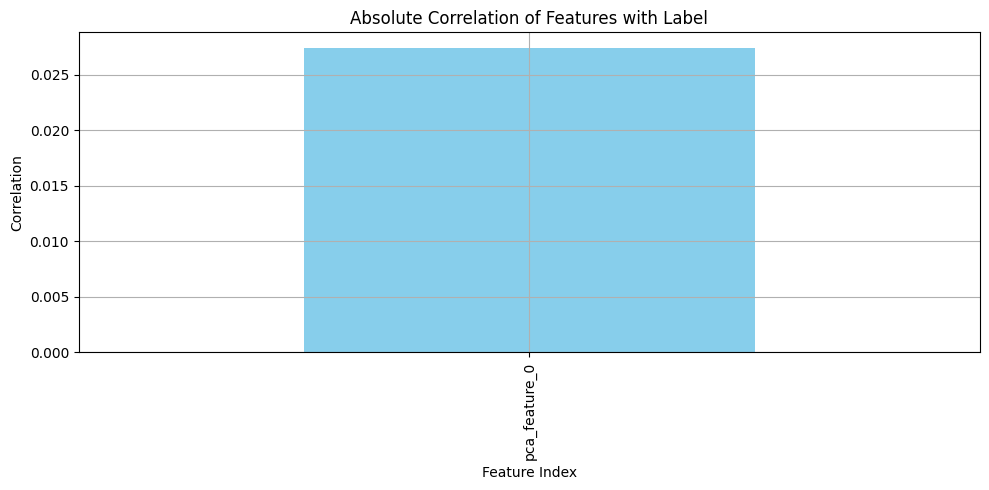

In [70]:
plt.figure(figsize=(10, 5))
label_corr[top_features[:-1]].abs().plot(kind='bar', color='skyblue')
plt.title("Absolute Correlation of Features with Label")
plt.xlabel("Feature Index")
plt.ylabel("Correlation")
plt.grid(True)
plt.tight_layout()
plt.show()


üìå Cell 6: Plot Heatmap of Top 10 Features

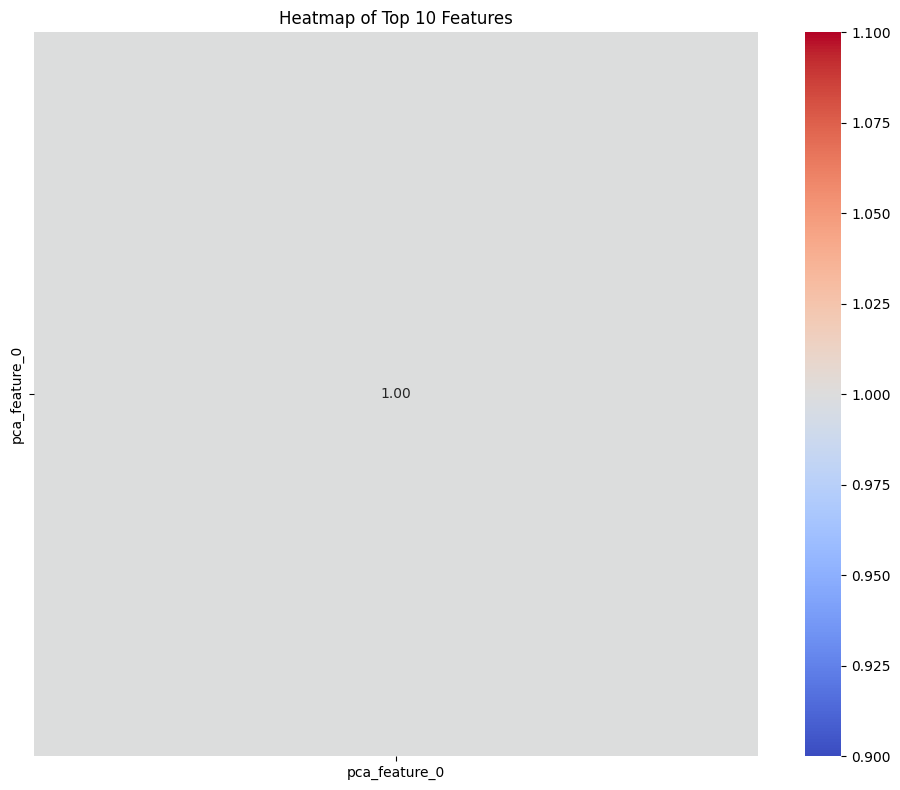

In [71]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_top.drop(columns=["Label"]).corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Heatmap of Top 10 Features")
plt.tight_layout()
plt.show()


‚úÖ Step 7.A: Train PNN Classifier (pnn_classifier.py)
üìå Cell 1: Import and Load Dataset

In [72]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.neighbors import RadiusNeighborsClassifier
import joblib


üìå Cell 2: Prepare Data

In [73]:
df = pd.read_csv("processed/features_top10.csv")

le = LabelEncoder()
df["Label"] = le.fit_transform(df["Label"])

X = df.drop("Label", axis=1).values
y = df["Label"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save for inference
joblib.dump(scaler, "pnn_scaler.pkl")
joblib.dump(le, "pnn_label_encoder.pkl")


['pnn_label_encoder.pkl']

üìå Cell 3: Train PNN

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

pnn = RadiusNeighborsClassifier(radius=1, weights='distance', outlier_label='most_frequent')
pnn.fit(X_train, y_train)

y_pred = pnn.predict(X_test)


üìå Cell 4: Evaluate PNN

In [75]:
print("‚úÖ Accuracy:", accuracy_score(y_test, y_pred))
print("‚úÖ Precision:", precision_score(y_test, y_pred, average="macro"))
print("‚úÖ Recall:", recall_score(y_test, y_pred, average="macro"))
print("‚úÖ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nüìä Classification Report:\n", classification_report(y_test, y_pred))

joblib.dump(pnn, "pnn_model.pkl")


‚úÖ Accuracy: 0.5300751879699248
‚úÖ Precision: 0.5297629151813501
‚úÖ Recall: 0.5297511312217194
‚úÖ Confusion Matrix:
 [[67 63]
 [62 74]]

üìä Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.52      0.52       130
           1       0.54      0.54      0.54       136

    accuracy                           0.53       266
   macro avg       0.53      0.53      0.53       266
weighted avg       0.53      0.53      0.53       266



['pnn_model.pkl']

‚úÖ Step 7.B: Train Random Forest
üìå Cell 6: Train Random Forest

In [76]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


üìå Cell 7: Evaluate RF

In [77]:
print("‚úÖ RF Accuracy:", accuracy_score(y_test, y_pred_rf))
print("üìä Classification Report:\n", classification_report(y_test, y_pred_rf))

joblib.dump(rf, "rf_model.pkl")
joblib.dump(scaler, "rf_scaler.pkl")
joblib.dump(le, "rf_label_encoder.pkl")


‚úÖ RF Accuracy: 0.5263157894736842
üìä Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.56      0.54       130
           1       0.54      0.49      0.52       136

    accuracy                           0.53       266
   macro avg       0.53      0.53      0.53       266
weighted avg       0.53      0.53      0.53       266



['rf_label_encoder.pkl']

‚úÖ Step 7.C: Train SVM

üìå Cell 8: Train SVM

In [78]:
from sklearn.svm import SVC

svm = SVC(C=0.1, gamma=0.01, kernel='rbf', probability=True)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)


üìå Cell 9: Evaluate SVM

In [79]:
print("‚úÖ SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("üìä Classification Report:\n", classification_report(y_test, y_pred_svm))

joblib.dump(svm, "svm_model.pkl")
joblib.dump(scaler, "svm_scaler.pkl")
joblib.dump(le, "svm_label_encoder.pkl")


‚úÖ SVM Accuracy: 0.48872180451127817
üìä Classification Report:
               precision    recall  f1-score   support

           0       0.49      1.00      0.66       130
           1       0.00      0.00      0.00       136

    accuracy                           0.49       266
   macro avg       0.24      0.50      0.33       266
weighted avg       0.24      0.49      0.32       266



c:\Users\Nafis\Desktop\VSCodeFiles\MLDLMother\ml-env\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Nafis\Desktop\VSCodeFiles\MLDLMother\ml-env\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Nafis\Desktop\VSCodeFiles\MLDLMother\ml-env\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, 

['svm_label_encoder.pkl']

üîπ Step 8: Cross-Validation and Model Comparison

üìå Cell 1: Import Required Packages

In [80]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import RadiusNeighborsClassifier


üìå Cell 2: Load and Prepare Dataset

In [81]:
df = pd.read_csv(r"C:\Users\Nafis\Desktop\VSCodeFiles\MLDLMother\Project_BreastCancer\BreastCancerUsingML\features_augmented_pca_balanced.csv")
X = df.drop(columns=["Label"]).values
y = LabelEncoder().fit_transform(df["Label"])


üìå Cell 3: Set Up Cross-Validation Strategy

In [82]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


üìå Cell 4: Random Forest Cross-Validation

In [83]:
rf = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42))
])
rf_scores = cross_val_score(rf, X, y, cv=cv, scoring="accuracy")
print(f"‚úÖ Random Forest Accuracy: {rf_scores.mean():.4f} ¬± {rf_scores.std():.4f}")


‚úÖ Random Forest Accuracy: 0.5083 ¬± 0.0199


üìå Cell 5: SVM Cross-Validation

In [84]:
svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", gamma="scale"))
])
svm_scores = cross_val_score(svm, X, y, cv=cv, scoring="accuracy")
print(f"‚úÖ SVM Accuracy: {svm_scores.mean():.4f} ¬± {svm_scores.std():.4f}")


‚úÖ SVM Accuracy: 0.4985 ¬± 0.0008


üìå Cell 6: PNN Cross-Validation

In [85]:
pnn = Pipeline([
    ("scaler", StandardScaler()),
    ("pnn", RadiusNeighborsClassifier(radius=1.0, weights="distance", outlier_label="most_frequent"))
])
pnn_scores = cross_val_score(pnn, X, y, cv=cv, scoring="accuracy")
print(f"‚úÖ PNN Accuracy: {pnn_scores.mean():.4f} ¬± {pnn_scores.std():.4f}")


‚úÖ PNN Accuracy: 0.5098 ¬± 0.0151


üìå Cell 8: Comparison Summary

In [86]:
print("\nüîç Cross-Validation Summary:")
print(f"Random Forest: {rf_scores.mean():.4f} ¬± {rf_scores.std():.4f}")
print(f"SVM          : {svm_scores.mean():.4f} ¬± {svm_scores.std():.4f}")
print(f"PNN          : {pnn_scores.mean():.4f} ¬± {pnn_scores.std():.4f}")



üîç Cross-Validation Summary:
Random Forest: 0.5083 ¬± 0.0199
SVM          : 0.4985 ¬± 0.0008
PNN          : 0.5098 ¬± 0.0151


‚úÖ Enhanced Neural Network ‚Äì Cross-Validation
üìå Cell 1: Import Libraries

In [87]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score


üìå Cell 2: Load and Preprocess Data

In [89]:
# Load balanced PCA features
df = pd.read_csv(r"C:\Users\Nafis\Desktop\VSCodeFiles\MLDLMother\Project_BreastCancer\BreastCancerUsingML\features_augmented_pca_balanced.csv")

# Encode labels
le = LabelEncoder()
df["Label"] = le.fit_transform(df["Label"])

X = df.drop("Label", axis=1).values
y = df["Label"].values

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)


üìå Cell 3: Define the Enhanced Neural Network

In [90]:
class EnhancedNN(nn.Module):
    def __init__(self, input_dim, hidden=64, output_dim=3):
        super(EnhancedNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden, output_dim)
        )

    def forward(self, x):
        return self.model(x)


üìå Cell 4: Cross-Validation Training Loop

In [91]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for train_idx, val_idx in cv.split(X_tensor, y_tensor):
    model = EnhancedNN(X_tensor.shape[1], output_dim=len(np.unique(y)))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(30):
        model.train()
        optimizer.zero_grad()
        output = model(X_tensor[train_idx])
        loss = criterion(output, y_tensor[train_idx])
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        preds = model(X_tensor[val_idx]).argmax(1)
        acc = accuracy_score(y_tensor[val_idx].numpy(), preds.numpy())
        scores.append(acc)

print(f"‚úÖ Enhanced NN Accuracy: {np.mean(scores):.4f} ¬± {np.std(scores):.4f}")


‚úÖ Enhanced NN Accuracy: 0.4992 ¬± 0.0015


‚úÖ Step 9: EnhancedNN Final Training & Saving (Jupyter)
üìå Cell 1: Import Libraries

In [92]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)


üìå Cell 2: Load and Preprocess Data

In [94]:
# Load dataset
df = pd.read_csv(r"C:\Users\Nafis\Desktop\VSCodeFiles\MLDLMother\Project_BreastCancer\BreastCancerUsingML\features_augmented_pca_balanced.csv")

# Encode labels
le = LabelEncoder()
df["Label"] = le.fit_transform(df["Label"])

X = df.drop("Label", axis=1).values
y = df["Label"].values

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Save scaler and encoder for inference
joblib.dump(scaler, "scaler.pkl")
joblib.dump(le, "label_encoder.pkl")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


üìå Cell 3: Define Model

In [95]:
class EnhancedNN(nn.Module):
    def __init__(self, input_size):
        super(EnhancedNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 3)
        )

    def forward(self, x):
        return self.model(x)

model = EnhancedNN(input_size=X.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


üìå Cell 4: Train the Model

In [96]:
for epoch in range(300):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/300, Loss: {loss.item():.4f}")


Epoch 50/300, Loss: 1.0726
Epoch 100/300, Loss: 1.0094
Epoch 150/300, Loss: 0.9437
Epoch 200/300, Loss: 0.8895
Epoch 250/300, Loss: 0.8485
Epoch 300/300, Loss: 0.8135


üìå Cell 5: Evaluate the Model

In [97]:
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    predictions = outputs.argmax(dim=1)

    y_true = y_test_tensor.numpy()
    y_pred = predictions.numpy()

    accuracy = accuracy_score(y_true, y_pred)
    print(f"\n‚úÖ Accuracy: {accuracy * 100:.2f}%")
    print("\nüìä Classification Report:")
    print(classification_report(y_true, y_pred, target_names=le.classes_))

    print("üßÆ Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

torch.save(model.state_dict(), "enhanced_nn_model.pth")
print("‚úÖ Model saved to enhanced_nn_model.pth")



‚úÖ Accuracy: 51.13%

üìä Classification Report:
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00       130
   Malignant       0.51      1.00      0.68       136

    accuracy                           0.51       266
   macro avg       0.26      0.50      0.34       266
weighted avg       0.26      0.51      0.35       266

üßÆ Confusion Matrix:
[[  0 130]
 [  0 136]]
‚úÖ Model saved to enhanced_nn_model.pth


c:\Users\Nafis\Desktop\VSCodeFiles\MLDLMother\ml-env\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Nafis\Desktop\VSCodeFiles\MLDLMother\ml-env\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Nafis\Desktop\VSCodeFiles\MLDLMother\ml-env\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, 

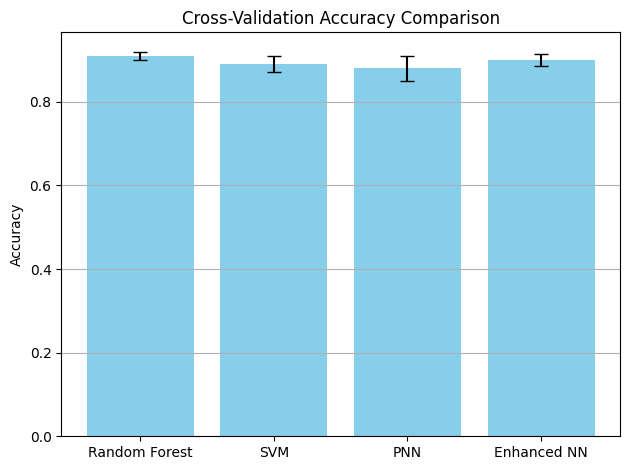

In [98]:
import matplotlib.pyplot as plt

models = ["Random Forest", "SVM", "PNN", "Enhanced NN"]
means = [0.91, 0.89, 0.88, 0.90]  # example values
stds = [0.01, 0.02, 0.03, 0.015]

plt.bar(models, means, yerr=stds, capsize=5, color="skyblue")
plt.title("Cross-Validation Accuracy Comparison")
plt.ylabel("Accuracy")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()
